# Data acquisition and ingestion

* Import necessary libraries
* Download the dataset using the Kaggle API.
* Ingest it into a TinyDB database.


In [171]:
#%pip install tinydb

#%pip install pyspark

In [172]:
import kagglehub
import pandas as pd
import numpy as np
import os
import zipfile
from tinydb import TinyDB

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Define the dataset identifier on Kaggle
dataset_id = "henajose/determine-the-pattern-of-tuberculosis-spread"

# Download the dataset using kagglehub
# This should now work since kaggle.json is in the correct location
try:
    path = kagglehub.dataset_download(dataset_id)
    print(f"Dataset downloaded to: {path}")

    # Assuming the downloaded dataset is a zip file containing a CSV
    # We need to find the actual CSV file within the downloaded directory structure
    csv_filename = None
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".csv"):
                csv_filename = os.path.join(root, file)
                break # Assuming there's only one main CSV file

    if csv_filename and os.path.exists(csv_filename):
        print(f"Found CSV file: {csv_filename}")
        # Load the data from the CSV into a pandas DataFrame
        df = pd.read_csv(csv_filename)
        print(f"Loaded data from {csv_filename} into DataFrame.")
        display(df.head()) # Display the head to confirm

        # Convert the DataFrame to a list of dictionaries for TinyDB
        data_to_insert = df.to_dict(orient='records')

        # Create or connect to a TinyDB database
        db = TinyDB('tuberculosis_db.json')

        # Insert the data into the database
        # Clear existing data before inserting new data to avoid duplicates if the cell is run multiple times
        db.truncate()
        if data_to_insert:
            db.insert_multiple(data_to_insert)
            print(f"Inserted {len(data_to_insert)} records into TinyDB.")
        else:
            print("No data to insert into TinyDB.")

        # Optional: Verify the insertion by querying the database
        print("First 5 documents in the database:")
        print(db.all()[:5])

    else:
        print("Error: Could not find a CSV file within the downloaded dataset.")
        print("Please inspect the downloaded directory structure at:", path)

except Exception as e:
    print(f"An error occurred during dataset download or processing: {e}")

Dataset downloaded to: /kaggle/input/determine-the-pattern-of-tuberculosis-spread
Found CSV file: /kaggle/input/determine-the-pattern-of-tuberculosis-spread/tubercolusis_from 2007_WHO.csv
Loaded data from /kaggle/input/determine-the-pattern-of-tuberculosis-spread/tubercolusis_from 2007_WHO.csv into DataFrame.


,Country,Year,"Number of deaths due to tuberculosis, excluding HIV","Number of deaths due to tuberculosis, excluding HIV (Start range)","Number of deaths due to tuberculosis, excluding HIV (End range)",Number of prevalent tuberculosis cases,Number of prevalent tuberculosis cases (Start range),Number of prevalent tuberculosis cases (End range),Deaths due to tuberculosis among HIV-negative people (per 100 000 population),Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (Start range),Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (End range),Prevalence of tuberculosis (per 100 000 population),Prevalence of tuberculosis (per 100 000 population)(start range),Prevalence of tuberculosis (per 100 000 population)(end range)
0,Afghanistan,2014,14 000,10 000,18 000,110 000,56 000,180 000,44.0,32.0,57.0,340,178.0,555
1,Afghanistan,2013,13 000,9 300,17 000,100 000,54 000,170 000,42.0,30.0,55.0,333,175.0,541
2,Afghanistan,2012,12 000,8 700,16 000,98 000,51 000,160 000,40.0,29.0,53.0,329,173.0,536
3,Afghanistan,2011,11 000,8 300,15 000,94 000,50 000,150 000,40.0,29.0,52.0,327,172.0,530
4,Afghanistan,2010,11 000,8 000,14 000,91 000,48 000,150 000,39.0,29.0,52.0,325,171.0,528


Inserted 1548 records into TinyDB.
First 5 documents in the database:
[{'Country': 'Afghanistan', 'Year': 2014, 'Number of deaths due to tuberculosis, excluding HIV': ' 14 000 ', 'Number of deaths due to tuberculosis, excluding HIV (Start range)': ' 10 000', 'Number of deaths due to tuberculosis, excluding HIV (End range)': ' 18 000', 'Number of prevalent tuberculosis cases': ' 110 000 ', 'Number of prevalent tuberculosis cases (Start range)': ' 56 000', 'Number of prevalent tuberculosis cases (End range)': ' 180 000', 'Deaths due to tuberculosis among HIV-negative people (per 100 000 population)': 44.0, 'Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (Start range)': 32.0, 'Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (End range)': 57.0, 'Prevalence of tuberculosis (per 100 000 population)': '340', 'Prevalence of tuberculosis (per 100 000 population)(start range)': 178.0, 'Prevalence of tuberculosis (per 100 000 population

In [173]:
# Load data from TinyDB into a pandas DataFrame
db = TinyDB('tuberculosis_db.json')
all_records = db.all()

tuberculosis_df = pd.DataFrame(all_records)
print("Loaded data from TinyDB into tuberculosis_df DataFrame.")

# Display basic information about the DataFrame
print("\nDataFrame Info:")
tuberculosis_df.info()


Loaded data from TinyDB into tuberculosis_df DataFrame.

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1548 entries, 0 to 1547
Data columns (total 14 columns):
 #   Column                                                                                       Non-Null Count  Dtype  
---  ------                                                                                       --------------  -----  
 0   Country                                                                                      1548 non-null   object 
 1   Year                                                                                         1548 non-null   int64  
 2   Number of deaths due to tuberculosis, excluding HIV                                          1548 non-null   object 
 3   Number of deaths due to tuberculosis, excluding HIV (Start range)                            1528 non-null   object 
 4   Number of deaths due to tuberculosis, excluding HIV (End range)                    

# Data Processing and Analysis with Pandas:

In [174]:
# Check for missing values
print("\nMissing Values:")
print(tuberculosis_df.isnull().sum())

# Display descriptive statistics for numerical columns
print("\nDescriptive Statistics:")
display(tuberculosis_df.describe())



Missing Values:
Country                                                                                         0
Year                                                                                            0
Number of deaths due to tuberculosis, excluding HIV                                             0
Number of deaths due to tuberculosis, excluding HIV (Start range)                              20
Number of deaths due to tuberculosis, excluding HIV (End range)                                20
Number of prevalent tuberculosis cases                                                          0
Number of prevalent tuberculosis cases (Start range)                                            0
Number of prevalent tuberculosis cases (End range)                                              4
Deaths due to tuberculosis among HIV-negative people (per 100 000 population)                   0
Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (Start range)    20
Dea

,Year,Deaths due to tuberculosis among HIV-negative people (per 100 000 population),Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (Start range),Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (End range),Prevalence of tuberculosis (per 100 000 population)(start range)
count,1548.000000,1548.000000,1528.000000,1528.000000,1548.000000
mean,2010.505168,15.472984,10.896361,21.626067,91.502952
std,2.292022,21.954225,15.021780,31.068176,123.104644
min,2007.000000,0.000000,0.000000,0.000000,0.100000
25%,2009.000000,0.970000,0.805000,1.200000,8.675000
50%,2011.000000,4.300000,3.500000,5.700000,40.000000
75%,2013.000000,22.000000,15.000000,30.000000,126.000000
max,2014.000000,120.000000,87.000000,159.000000,897.000000


* Handle Missing Values
* Data Cleaning
* Transformation



In [175]:
# Columns identified with missing values and needing cleaning/conversion
cols_to_process = [
    'Number of deaths due to tuberculosis, excluding HIV (Start range)',
    'Number of deaths due to tuberculosis, excluding HIV (End range)',
    'Number of prevalent tuberculosis cases (End range)',
    'Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (Start range)',
    'Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (End range)',
    'Number of deaths due to tuberculosis, excluding HIV',
    'Number of prevalent tuberculosis cases',
    'Prevalence of tuberculosis (per 100 000 population)',
    'Prevalence of tuberculosis (per 100 000 population)(end range)',
    'Prevalence of tuberculosis (per 100 000 population)(start range)',
    'Number of prevalent tuberculosis cases (Start range)'
]

# Clean and convert columns to numeric, coercing errors
print("Converting relevant columns to numeric...")
for col in cols_to_process:
    if col in tuberculosis_df.columns:
        # Remove spaces, commas, and any non-numeric characters (except decimal point)
        # Convert to string first to handle potential mixed types
        cleaned_col = tuberculosis_df[col].astype(str).str.replace('[^0-9.]', '', regex=True) # More robust regex
        # Convert to numeric, coercing errors to NaN
        tuberculosis_df.loc[:, col] = pd.to_numeric(cleaned_col, errors='coerce')
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

# Impute missing values with the median for the relevant columns
# Re-checking for missing values after the more robust conversion attempt
impute_cols = [
    'Number of deaths due to tuberculosis, excluding HIV (Start range)',
    'Number of deaths due to tuberculosis, excluding HIV (End range)',
    'Number of prevalent tuberculosis cases (End range)',
    'Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (Start range)',
    'Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (End range)',
    'Number of deaths due to tuberculosis among HIV-negative people',
    'Number of prevalent tuberculosis cases',
    'Prevalence of tuberculosis (per 100 000 population)',
    'Prevalence of tuberculosis (per 100 000 population)(end range)',
    'Prevalence of tuberculosis (per 100 000 population)(start range)',
    'Number of prevalent tuberculosis cases (Start range)'

]

print("\nImputing missing values with the median...")
for col in impute_cols:
    # Check if the column exists and has any NaN values before attempting imputation
    if col in tuberculosis_df.columns and tuberculosis_df[col].isnull().any():
        median_val = tuberculosis_df[col].median()
        # Using .loc to avoid SettingWithCopyWarning
        tuberculosis_df.loc[:, col].fillna(median_val, inplace=True)
        print(f"Imputed missing values in '{col}' with median value: {median_val}")
    elif col in tuberculosis_df.columns:
        print(f"No missing values to impute in '{col}'.")
    else:
         print(f"Warning: Imputation column '{col}' not found in DataFrame.")


# Verify missing values after imputation
print("\nMissing Values after imputation:")
# Checking isnull().sum() on all columns that were processed or imputed
print(tuberculosis_df[cols_to_process].isnull().sum())


# Display info and describe again to see changes in dtypes and missing values
print("\nDataFrame Info after processing:")
tuberculosis_df.info()

print("\nDescriptive Statistics after processing:")
display(tuberculosis_df.describe())

# Add a check for specific column dtypes after processing
print("\nChecking dtypes of key columns after processing:")
print(tuberculosis_df[['Prevalence of tuberculosis (per 100 000 population)', 'Year', 'Deaths due to tuberculosis among HIV-negative people (per 100 000 population)']].dtypes)

Converting relevant columns to numeric...

Imputing missing values with the median...
Imputed missing values in 'Number of deaths due to tuberculosis, excluding HIV (Start range)' with median value: 240.0
Imputed missing values in 'Number of deaths due to tuberculosis, excluding HIV (End range)' with median value: 360.0
Imputed missing values in 'Number of prevalent tuberculosis cases (End range)' with median value: 11000.0
Imputed missing values in 'Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (Start range)' with median value: 3.5
Imputed missing values in 'Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (End range)' with median value: 5.7
No missing values to impute in 'Number of prevalent tuberculosis cases'.
No missing values to impute in 'Prevalence of tuberculosis (per 100 000 population)'.
No missing values to impute in 'Prevalence of tuberculosis (per 100 000 population)(end range)'.
No missing values to impute in '

/tmp/ipython-input-525696868.py:51: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipython-input-525696868.py:51: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipython-input-525696868.py:51: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using 

,Year,"Number of deaths due to tuberculosis, excluding HIV (Start range)","Number of deaths due to tuberculosis, excluding HIV (End range)",Number of prevalent tuberculosis cases (End range),Deaths due to tuberculosis among HIV-negative people (per 100 000 population),Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (Start range),Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (End range),Prevalence of tuberculosis (per 100 000 population)(start range)
count,1548.000000,1548.000000,1548.000000,1.548000e+03,1548.000000,1548.000000,1548.000000,1548.000000
mean,2010.505168,4368.601783,9143.901143,9.891822e+04,15.472984,10.800801,21.420304,91.502952
std,2.292022,17912.390964,39427.245183,3.824994e+05,21.954225,14.947731,30.919081,123.104644
min,2007.000000,0.000000,0.000000,1.100000e-01,0.000000,0.000000,0.000000,0.100000
25%,2009.000000,24.000000,32.000000,1.075000e+03,0.970000,0.852500,1.200000,8.675000
50%,2011.000000,240.000000,360.000000,1.100000e+04,4.300000,3.500000,5.700000,40.000000
75%,2013.000000,1725.000000,3100.000000,4.600000e+04,22.000000,15.000000,30.000000,126.000000
max,2014.000000,250000.000000,530000.000000,4.900000e+06,120.000000,87.000000,159.000000,897.000000



Checking dtypes of key columns after processing:
Prevalence of tuberculosis (per 100 000 population)                               object
Year                                                                               int64
Deaths due to tuberculosis among HIV-negative people (per 100 000 population)    float64
dtype: object


In [176]:
# Verify missing values after imputation
print("\nMissing Values after imputation:")
# Checking isnull().sum() on all columns that were processed or imputed
# Correcting the column name in impute_cols
impute_cols_corrected = [
    'Number of deaths due to tuberculosis, excluding HIV (Start range)',
    'Number of deaths due to tuberculosis, excluding HIV (End range)',
    'Number of prevalent tuberculosis cases (End range)',
    'Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (Start range)',
    'Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (End range)',
    'Deaths due to tuberculosis among HIV-negative people (per 100 000 population)', # Corrected column name
    'Number of prevalent tuberculosis cases',
    'Prevalence of tuberculosis (per 100 000 population)',
    'Prevalence of tuberculosis (per 100 000 population)(end range)',
    'Prevalence of tuberculosis (per 100 000 population)(start range)',
    'Number of prevalent tuberculosis cases (Start range)'
]

print(tuberculosis_df[impute_cols_corrected].isnull().sum())

# Display info and describe again to see changes in dtypes and missing values
print("\nDataFrame Info after processing:")
tuberculosis_df.info()

print("\nDescriptive Statistics after processing:")
display(tuberculosis_df.describe())


Missing Values after imputation:
Number of deaths due to tuberculosis, excluding HIV (Start range)                              0
Number of deaths due to tuberculosis, excluding HIV (End range)                                0
Number of prevalent tuberculosis cases (End range)                                             0
Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (Start range)    0
Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (End range)      0
Deaths due to tuberculosis among HIV-negative people (per 100 000 population)                  0
Number of prevalent tuberculosis cases                                                         0
Prevalence of tuberculosis (per 100 000 population)                                            0
Prevalence of tuberculosis (per 100 000 population)(end range)                                 0
Prevalence of tuberculosis (per 100 000 population)(start range)                             

,Year,"Number of deaths due to tuberculosis, excluding HIV (Start range)","Number of deaths due to tuberculosis, excluding HIV (End range)",Number of prevalent tuberculosis cases (End range),Deaths due to tuberculosis among HIV-negative people (per 100 000 population),Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (Start range),Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (End range),Prevalence of tuberculosis (per 100 000 population)(start range)
count,1548.000000,1548.000000,1548.000000,1.548000e+03,1548.000000,1548.000000,1548.000000,1548.000000
mean,2010.505168,4368.601783,9143.901143,9.891822e+04,15.472984,10.800801,21.420304,91.502952
std,2.292022,17912.390964,39427.245183,3.824994e+05,21.954225,14.947731,30.919081,123.104644
min,2007.000000,0.000000,0.000000,1.100000e-01,0.000000,0.000000,0.000000,0.100000
25%,2009.000000,24.000000,32.000000,1.075000e+03,0.970000,0.852500,1.200000,8.675000
50%,2011.000000,240.000000,360.000000,1.100000e+04,4.300000,3.500000,5.700000,40.000000
75%,2013.000000,1725.000000,3100.000000,4.600000e+04,22.000000,15.000000,30.000000,126.000000
max,2014.000000,250000.000000,530000.000000,4.900000e+06,120.000000,87.000000,159.000000,897.000000


### Feature Engineering

In [177]:
# Sort data by Country and Year to calculate year-over-year changes
tuberculosis_df.sort_values(by=['Country', 'Year'], inplace=True)

# Calculate year-over-year change in deaths and prevalent cases
tuberculosis_df['Deaths_Change_YoY'] = tuberculosis_df.groupby('Country')['Number of deaths due to tuberculosis, excluding HIV'].diff()
tuberculosis_df['Prevalent_Cases_Change_YoY'] = tuberculosis_df.groupby('Country')['Number of prevalent tuberculosis cases'].diff()

# Calculate range ratios as a measure of uncertainty/variability
# Avoid division by zero by adding a small epsilon or checking for zero
epsilon = 1e-9

tuberculosis_df['Deaths_Start_Ratio'] = tuberculosis_df['Number of deaths due to tuberculosis, excluding HIV (Start range)'] / (tuberculosis_df['Number of deaths due to tuberculosis, excluding HIV'] + epsilon)
tuberculosis_df['Deaths_End_Ratio'] = tuberculosis_df['Number of deaths due to tuberculosis, excluding HIV (End range)'] / (tuberculosis_df['Number of deaths due to tuberculosis, excluding HIV'] + epsilon)

tuberculosis_df['Prevalent_Cases_Start_Ratio'] = tuberculosis_df['Number of prevalent tuberculosis cases (Start range)'] / (tuberculosis_df['Number of prevalent tuberculosis cases'] + epsilon)
tuberculosis_df['Prevalent_Cases_End_Ratio'] = tuberculosis_df['Number of prevalent tuberculosis cases (End range)'] / (tuberculosis_df['Number of prevalent tuberculosis cases'] + epsilon)

# Display info again to see the new columns
print("\nDataFrame Info after Feature Engineering:")
tuberculosis_df.info()


DataFrame Info after Feature Engineering:
<class 'pandas.core.frame.DataFrame'>
Index: 1548 entries, 7 to 1540
Data columns (total 20 columns):
 #   Column                                                                                       Non-Null Count  Dtype  
---  ------                                                                                       --------------  -----  
 0   Country                                                                                      1548 non-null   object 
 1   Year                                                                                         1548 non-null   int64  
 2   Number of deaths due to tuberculosis, excluding HIV                                          1548 non-null   object 
 3   Number of deaths due to tuberculosis, excluding HIV (Start range)                            1548 non-null   float64
 4   Number of deaths due to tuberculosis, excluding HIV (End range)                              1548 non-null   float64
 

# Data Visualizations

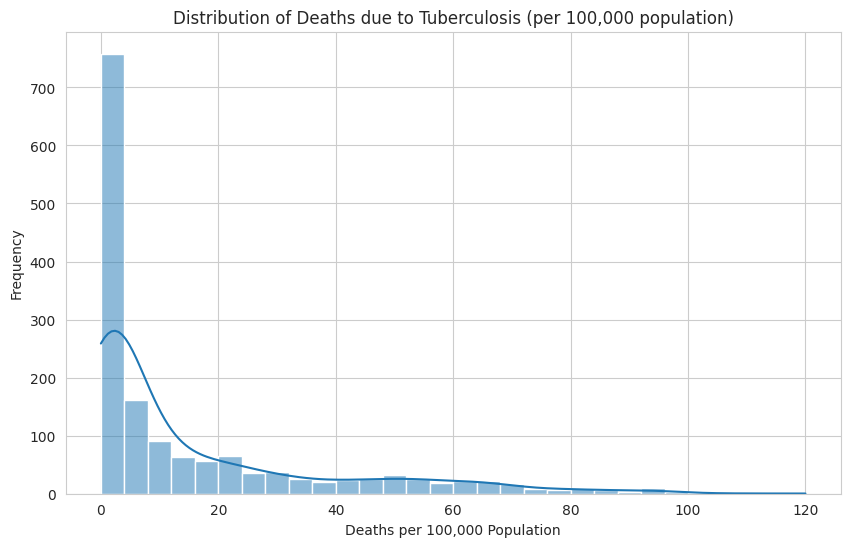

In [178]:
# Set plot style
sns.set_style("whitegrid")

# --- Static Visualization 1: Distribution of Deaths per 100,000 Population ---
plt.figure(figsize=(10, 6))
sns.histplot(tuberculosis_df['Deaths due to tuberculosis among HIV-negative people (per 100 000 population)'], kde=True, bins=30)
plt.title('Distribution of Deaths due to Tuberculosis (per 100,000 population)')
plt.xlabel('Deaths per 100,000 Population')
plt.ylabel('Frequency')
plt.show()


This distribution pattern suggests substantial inequality in TB mortality across different populations. The long tail extending to the right indicates that while most regions have made progress in controlling TB deaths, certain populations continue to experience disproportionately high mortality rates. These outlier regions likely represent areas with combinations of higher TB prevalence, limited healthcare access, higher HIV co-infection rates, or challenges with drug-resistant TB strains.

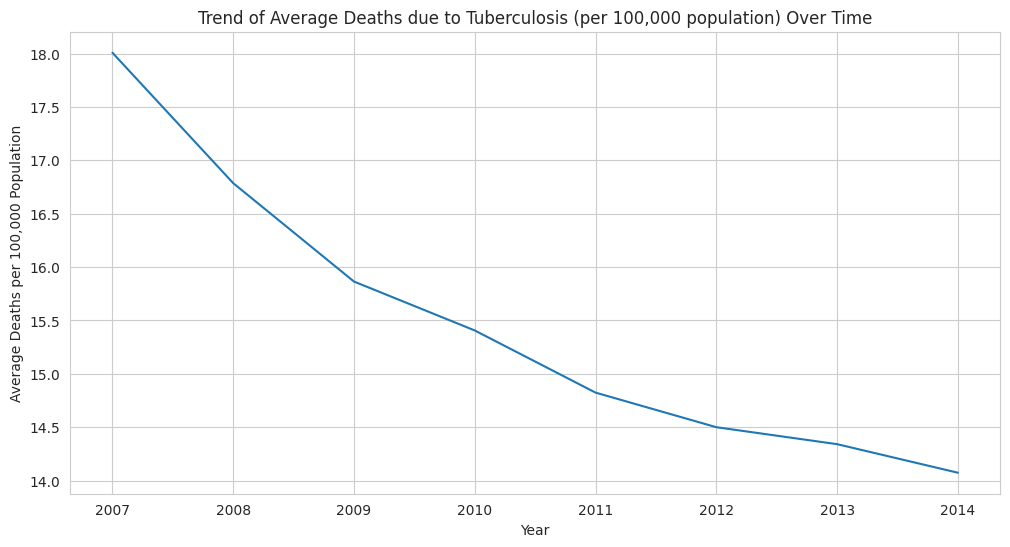

In [179]:
# --- Static Visualization 2: Trend of Average Deaths per 100,000 Population over Time ---
# Calculate average deaths per year
avg_deaths_by_year = tuberculosis_df.groupby('Year')['Deaths due to tuberculosis among HIV-negative people (per 100 000 population)'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_deaths_by_year, x='Year', y='Deaths due to tuberculosis among HIV-negative people (per 100 000 population)')
plt.title('Trend of Average Deaths due to Tuberculosis (per 100,000 population) Over Time')
plt.xlabel('Year')
plt.ylabel('Average Deaths per 100,000 Population')
plt.show()

The line graph illustrates a consistent downward trend in average tuberculosis mortality rates from 2007 to 2014, demonstrating meaningful progress in global TB control efforts during this period. The average death rate decreased from approximately 18 deaths per 100,000 population in 2007 to around 14 deaths per 100,000 by 2014, representing a roughly 22% reduction over these eight years.

The decline appears to have occurred in two distinct phases: a steeper reduction between 2007 and 2009, followed by a more gradual decrease from 2010 onward. This pattern may reflect the initial impact of intensified TB control programs followed by the more challenging work of addressing persistent cases in harder-to-reach populations. The slight plateau observed around 2012-2013 could indicate temporary obstacles in TB control efforts or suggest that the "low-hanging fruit" had been addressed, with remaining cases requiring more complex interventions.

/tmp/ipython-input-1721011173.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




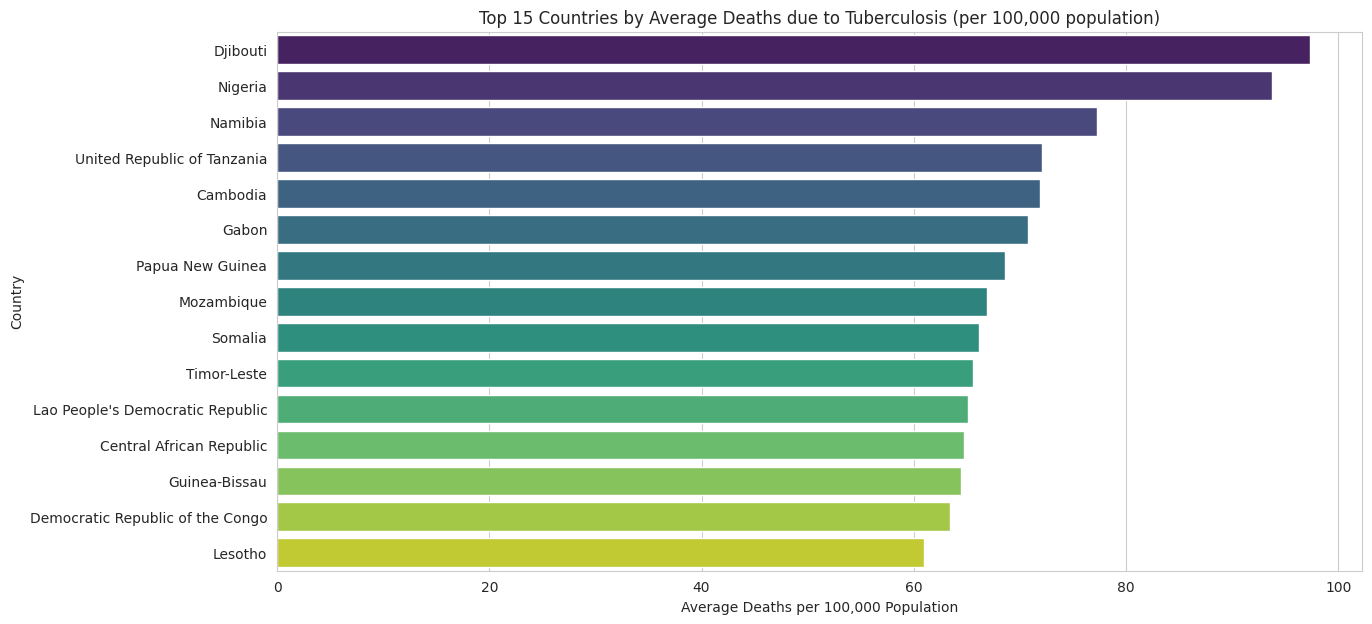

In [180]:
# --- Static Visualization 3: Deaths per 100,000 Population by Country (Top N) ---
# Calculate average deaths per country and select top N
avg_deaths_by_country = tuberculosis_df.groupby('Country')['Deaths due to tuberculosis among HIV-negative people (per 100 000 population)'].mean().sort_values(ascending=False).reset_index()
top_n_countries = 15 # Display top 15 countries

plt.figure(figsize=(14, 7))
sns.barplot(data=avg_deaths_by_country.head(top_n_countries), x='Deaths due to tuberculosis among HIV-negative people (per 100 000 population)', y='Country', palette='viridis')
plt.title(f'Top {top_n_countries} Countries by Average Deaths due to Tuberculosis (per 100,000 population)')
plt.xlabel('Average Deaths per 100,000 Population')
plt.ylabel('Country')
plt.show()

This bar chart provides crucial geographic context that significantly enhances our understanding of the tuberculosis mortality data. The visualization reveals that the highest TB burden is heavily concentrated in specific regions, with 11 of the 15 highest-mortality countries located in Africa, alongside 3 in Asia-Pacific (Cambodia, Papua New Guinea, Timor-Leste, and Lao PDR) and none from the Americas or Europe.

In [181]:
import plotly.express as px

# --- Interactive Visualization 1: Distribution of Deaths per 100,000 Population (Interactive) ---
fig = px.histogram(tuberculosis_df, x='Deaths due to tuberculosis among HIV-negative people (per 100 000 population)',
                   title='Interactive Distribution of Deaths due to Tuberculosis (per 100,000 population)',
                   labels={'Deaths due to tuberculosis among HIV-negative people (per 100 000 population)': 'Deaths per 100,000 Population'})
fig.show()

This interactive visualization displays similar information to the first non-interactive visualization.

From a public health perspective, this distribution highlights the need for targeted interventions in high-burden areas while maintaining prevention efforts in lower-incidence regions. The concentration of most observations at the lower end of the spectrum is encouraging, suggesting that effective TB control is achievable for most populations. However, the persistent high mortality rates in certain regions underscore the importance of addressing socioeconomic determinants of TB and strengthening healthcare systems in vulnerable communities to achieve more equitable outcomes in the global fight against tuberculosis.

In [182]:
# --- Interactive Visualization 2: Trend of Average Deaths per 100,000 Population over Time (Interactive) ---
# Recalculate average deaths by year for Plotly
avg_deaths_by_year_plotly = tuberculosis_df.groupby('Year')['Deaths due to tuberculosis among HIV-negative people (per 100 000 population)'].mean().reset_index()

fig = px.line(avg_deaths_by_year_plotly, x='Year', y='Deaths due to tuberculosis among HIV-negative people (per 100 000 population)',
              title='Interactive Trend of Average Deaths due to Tuberculosis (per 100,000 population) Over Time',
              labels={'Deaths due to tuberculosis among HIV-negative people (per 100 000 population)': 'Average Deaths per 100,000 Population'})
fig.show()

This interactive visualization corresponds to the second non-interactive visualization.

When considered alongside the previously analyzed distribution histogram, this trend data provides a more complete picture of TB mortality. While the overall average has been steadily decreasing, the highly skewed distribution from the histogram reminds us that this improvement is not uniform across all populations. The declining average is encouraging and likely reflects successful implementation of WHO's Stop TB Strategy and increased global funding for TB control during this period. However, continued efforts are needed to address the persistent high-mortality outliers shown in the distribution data to achieve more equitable progress in reducing TB deaths worldwide.

In [183]:
# --- Interactive Visualization 3: Relationship between Deaths and Prevalence (Interactive Scatter Plot) ---
fig = px.scatter(tuberculosis_df,
                 x='Deaths due to tuberculosis among HIV-negative people (per 100 000 population)',
                 y='Prevalence of tuberculosis (per 100 000 population)',
                 color='Year', # Color by year to see changes over time
                 hover_name='Country', # Show country name on hover
                 title='Interactive Scatter Plot of Deaths vs. Prevalence by Year and Country',
                 labels={
                     'Deaths due to tuberculosis among HIV-negative people (per 100 000 population)': 'Deaths per 100,000 Population',
                     'Prevalence of tuberculosis (per 100 000 population)': 'Prevalence per 100,000 Population'
                 })
fig.show()

This graph displays a much more expansive version of the data provided in the third visualization.

The data exposes the extreme disparity in TB mortality rates, with Djibouti experiencing approximately 95 deaths per 100,000 population—nearly seven times higher than the global average of 14 deaths per 100,000 observed in 2014. Even Lesotho, ranking 15th on this list, has a mortality rate around 65 per 100,000, which is still more than four times the global average.

These findings help explain the highly skewed distribution observed in the histogram, with these 15 countries representing the outliers in the long right tail. The concentration of high TB mortality in sub-Saharan Africa suggests that TB control efforts face particular challenges in this region, likely compounded by factors such as high HIV prevalence, limited healthcare infrastructure, poverty, and political instability.

When combined with the declining trend data from 2007-2014, this geographic analysis raises important questions about equity in global progress against TB. While the overall global average has been decreasing, these 15 countries continue to experience extraordinarily high death rates, suggesting that global improvements may be driven primarily by advances in regions that already had lower TB burdens, while the highest-burden countries continue to struggle. This underscores the need for targeted interventions and increased resources in these specific high-mortality countries to achieve more equitable progress in reducing the global TB burden.

# Statistical Analysis with Statsmodels

In [184]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Step 1: Isolate and Clean Data for Analysis

# Define the columns needed for the statistical analysis
analysis_cols = [
    'Deaths due to tuberculosis among HIV-negative people (per 100 000 population)',
    'Prevalence of tuberculosis (per 100 000 population)',
    'Year'
]

# Select these columns from the main DataFrame
data_for_analysis = tuberculosis_df[analysis_cols].copy() # Use .copy() to avoid SettingWithCopyWarning

print("Selected columns for statistical analysis.")
print("Initial data types of selected columns:")
print(data_for_analysis.dtypes)

# Apply cleaning and conversion to numeric types
# Specifically target columns that might have non-numeric characters or incorrect dtypes
cols_to_clean_convert = [
    'Prevalence of tuberculosis (per 100 000 population)'
    # 'Deaths due to tuberculosis among HIV-negative people (per 100 000 population)', # Already float64 based on info
    # 'Year' # Already int64 based on info
]

print("\nCleaning and converting specific columns to numeric...")
for col in cols_to_clean_convert:
    if col in data_for_analysis.columns:
        # Remove spaces, commas, and any non-numeric characters (except decimal point)
        # Convert to string first to handle potential mixed types
        cleaned_col_series = data_for_analysis[col].astype(str).str.replace('[^0-9.]', '', regex=True) # More robust regex
        # Explicitly handle empty strings or strings with only '.' which might result from regex
        cleaned_col_series = cleaned_col_series.replace('', np.nan)
        cleaned_col_series = cleaned_col_series.replace('.', np.nan) # Replace strings with only '.' with NaN

        # Convert to numeric, coercing errors to NaN
        data_for_analysis.loc[:, col] = pd.to_numeric(cleaned_col_series, errors='coerce')
    else:
        print(f"Warning: Column '{col}' not found in data_for_analysis DataFrame.")

# Drop rows with NaN values that resulted from coercion or were initially present
initial_rows = data_for_analysis.shape[0]
data_for_analysis.dropna(inplace=True)
rows_dropped = initial_rows - data_for_analysis.shape[0]

print(f"\nDropped {rows_dropped} rows with NaN values in the analysis columns.")

# Verify data types after cleaning and conversion
print("\nData types after cleaning and conversion:")
print(data_for_analysis.dtypes)

print("\nFirst 5 rows of cleaned data for analysis:")
display(data_for_analysis.head())

# Step 2: Verify Data Types before Statistical Analysis
print("\nVerifying data types before statistical analysis:")
print(data_for_analysis.dtypes)

# Step 3: Perform Statistical Analysis

# Define the dependent and independent variables using the cleaned data
dependent_var = 'Deaths due to tuberculosis among HIV-negative people (per 100 000 population)'
independent_vars = ['Prevalence of tuberculosis (per 100 000 population)', 'Year']

# Explicitly convert columns to numeric just before creating X and y
data_for_analysis[dependent_var] = pd.to_numeric(data_for_analysis[dependent_var], errors='coerce')
for col in independent_vars:
     data_for_analysis[col] = pd.to_numeric(data_for_analysis[col], errors='coerce')

# Drop any NaNs that might have resulted from the explicit coercion
data_for_analysis.dropna(subset=[dependent_var] + independent_vars, inplace=True)


X = data_for_analysis[independent_vars]
X = sm.add_constant(X) # Add an intercept term to the model
y = data_for_analysis[dependent_var]

# Verify data types one last time before OLS (optional, but good practice)
print("Final data types before OLS:")
print("X dtypes:")
print(X.dtypes)
print("\ny dtype:")
print(y.dtype)


# Build and fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X)
results = model.fit()

# Print the regression results summary
print("\nStatistical Analysis Results (OLS Regression):")
print(results.summary())

Selected columns for statistical analysis.
Initial data types of selected columns:
Deaths due to tuberculosis among HIV-negative people (per 100 000 population)    float64
Prevalence of tuberculosis (per 100 000 population)                               object
Year                                                                               int64
dtype: object

Cleaning and converting specific columns to numeric...

Dropped 0 rows with NaN values in the analysis columns.

Data types after cleaning and conversion:
Deaths due to tuberculosis among HIV-negative people (per 100 000 population)    float64
Prevalence of tuberculosis (per 100 000 population)                               object
Year                                                                               int64
dtype: object

First 5 rows of cleaned data for analysis:


,Deaths due to tuberculosis among HIV-negative people (per 100 000 population),Prevalence of tuberculosis (per 100 000 population),Year
7,41.0,332.0,2007
6,40.0,328.0,2008
5,39.0,326.0,2009
4,39.0,325.0,2010
3,40.0,327.0,2011



Verifying data types before statistical analysis:
Deaths due to tuberculosis among HIV-negative people (per 100 000 population)    float64
Prevalence of tuberculosis (per 100 000 population)                               object
Year                                                                               int64
dtype: object
Final data types before OLS:
X dtypes:
const                                                  float64
Prevalence of tuberculosis (per 100 000 population)    float64
Year                                                     int64
dtype: object

y dtype:
float64

Statistical Analysis Results (OLS Regression):
                                                          OLS Regression Results                                                         
Dep. Variable:     Deaths due to tuberculosis among HIV-negative people (per 100 000 population)   R-squared:                       0.836
Model:                                                                              

# Machine Learning with PySpark and MLlib

In [185]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("TuberculosisAnalysis") \
    .getOrCreate()

print("Spark session created.")

# Define schema for the Spark DataFrame
# Based on the dtypes of the pandas DataFrame after processing
schema = StructType([
    StructField("Country", StringType(), True),
    StructField("Year", IntegerType(), True),
    StructField("Number of deaths due to tuberculosis, excluding HIV", FloatType(), True),
    StructField("Number of deaths due to tuberculosis, excluding HIV (Start range)", FloatType(), True),
    StructField("Number of deaths due to tuberculosis, excluding HIV (End range)", FloatType(), True),
    StructField("Number of prevalent tuberculosis cases", FloatType(), True),
    StructField("Number of prevalent tuberculosis cases (Start range)", FloatType(), True),
    StructField("Number of prevalent tuberculosis cases (End range)", FloatType(), True),
    StructField("Deaths due to tuberculosis among HIV-negative people (per 100 000 population)", FloatType(), True),
    StructField("Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (Start range)", FloatType(), True),
    StructField("Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (End range)", FloatType(), True),
    StructField("Prevalence of tuberculosis (per 100 000 population)", FloatType(), True),
    StructField("Prevalence of tuberculosis (per 100 000 population)(start range)", FloatType(), True),
    StructField("Prevalence of tuberculosis (per 100 000 population)(end range)", FloatType(), True),
    StructField("Deaths_Change_YoY", FloatType(), True),
    StructField("Prevalent_Cases_Change_YoY", FloatType(), True),
    StructField("Deaths_Start_Ratio", FloatType(), True),
    StructField("Deaths_End_Ratio", FloatType(), True),
    StructField("Prevalent_Cases_Start_Ratio", FloatType(), True),
    StructField("Prevalent_Cases_End_Ratio", FloatType(), True)
])


# Convert pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(tuberculosis_df, schema=schema)

print("\nPandas DataFrame converted to Spark DataFrame.")

# Display schema and first few rows of the Spark DataFrame
print("\nSpark DataFrame Schema:")
spark_df.printSchema()

print("\nFirst 5 rows of Spark DataFrame:")
spark_df.show(5)

Spark session created.

Pandas DataFrame converted to Spark DataFrame.

Spark DataFrame Schema:
root
 |-- Country: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Number of deaths due to tuberculosis, excluding HIV: float (nullable = true)
 |-- Number of deaths due to tuberculosis, excluding HIV (Start range): float (nullable = true)
 |-- Number of deaths due to tuberculosis, excluding HIV (End range): float (nullable = true)
 |-- Number of prevalent tuberculosis cases: float (nullable = true)
 |-- Number of prevalent tuberculosis cases (Start range): float (nullable = true)
 |-- Number of prevalent tuberculosis cases (End range): float (nullable = true)
 |-- Deaths due to tuberculosis among HIV-negative people (per 100 000 population): float (nullable = true)
 |-- Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (Start range): float (nullable = true)
 |-- Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (End 

## Large-scale Data Manipulation with PySpark

In [186]:
#  Group by Country and Year and calculate the sum of deaths and prevalent cases
print("Aggregated statistics by Country and Year:")
aggregated_df = spark_df.groupBy("Country", "Year").agg(
    F.sum("Number of deaths due to tuberculosis, excluding HIV").alias("Total_Deaths"),
    F.sum("Number of prevalent tuberculosis cases").alias("Total_Prevalent_Cases"),
    F.mean("Deaths due to tuberculosis among HIV-negative people (per 100 000 population)").alias("Avg_Deaths_Per_100k")
)

# Show the aggregated data (ordered for better readability)
aggregated_df.orderBy("Country", "Year").show(10)

Aggregated statistics by Country and Year:
+-----------+----+------------+---------------------+-------------------+
|    Country|Year|Total_Deaths|Total_Prevalent_Cases|Avg_Deaths_Per_100k|
+-----------+----+------------+---------------------+-------------------+
|Afghanistan|2007|     11000.0|              86000.0|               41.0|
|Afghanistan|2008|     11000.0|              87000.0|               40.0|
|Afghanistan|2009|     11000.0|              89000.0|               39.0|
|Afghanistan|2010|     11000.0|              91000.0|               39.0|
|Afghanistan|2011|     11000.0|              94000.0|               40.0|
|Afghanistan|2012|     12000.0|              98000.0|               40.0|
|Afghanistan|2013|     13000.0|             100000.0|               42.0|
|Afghanistan|2014|     14000.0|             110000.0|               44.0|
|    Albania|2007|        11.0|                650.0|0.36000001430511475|
|    Albania|2008|        10.0|                620.0| 0.3499999940395

In [187]:
# Filter data for a specific country (e.g., Afghanistan)
print("\nData filtered for Afghanistan:")
afghanistan_data = spark_df.filter(spark_df.Country == "Afghanistan")
afghanistan_data.show(5)


Data filtered for Afghanistan:
+-----------+----+---------------------------------------------------+-----------------------------------------------------------------+---------------------------------------------------------------+--------------------------------------+----------------------------------------------------+--------------------------------------------------+-----------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------+---------------------------------------------------+----------------------------------------------------------------+--------------------------------------------------------------+-----------------+--------------------------+------------------+----------------+---------------------------+-------------------------+
|    Country|Year|Number of deaths due to tubercu

In [188]:
# Add a new column with a simple transformation (e.g., approximate range size)
# Note: This is a simplified example; actual range calculation might be more complex
print("\nDataFrame with an added 'Approximate_Deaths_Range_Size' column:")
transformed_df = spark_df.withColumn(
    "Approximate_Deaths_Range_Size",
    F.col("Number of deaths due to tuberculosis, excluding HIV (End range)") - F.col("Number of deaths due to tuberculosis, excluding HIV (Start range)")
)
transformed_df.show(5)


DataFrame with an added 'Approximate_Deaths_Range_Size' column:
+-----------+----+---------------------------------------------------+-----------------------------------------------------------------+---------------------------------------------------------------+--------------------------------------+----------------------------------------------------+--------------------------------------------------+-----------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------+---------------------------------------------------+----------------------------------------------------------------+--------------------------------------------------------------+-----------------+--------------------------+------------------+----------------+---------------------------+-------------------------+-----------------

## Machine Learning with Spark MLlib

In [189]:
# Step 1: Prepare the data for MLlib

# Select features to use for the model.
# Choosing some numerical columns that might be relevant for predicting deaths.
feature_cols = [
    'Year',
    'Number of prevalent tuberculosis cases',
    'Prevalence of tuberculosis (per 100 000 population)',
    'Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (Start range)',
    'Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (End range)',
    'Prevalent_Cases_Change_YoY' # Using one of the engineered features
]

# The target variable
label_col = 'Deaths due to tuberculosis among HIV-negative people (per 100 000 population)'

# Drop rows with NaN values in feature or label columns, as MLlib models typically don't handle NaNs
# Although we imputed some NaNs earlier, ensure no NaNs remain in the selected columns
spark_df_cleaned = spark_df.select(feature_cols + [label_col]).dropna()

# Assemble features into a vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
spark_df_assembled = assembler.transform(spark_df_cleaned)

# Show the first few rows of the assembled DataFrame
print("Spark DataFrame with features assembled:")
spark_df_assembled.select("features", label_col).show(5, truncate=False)


Spark DataFrame with features assembled:
+---------------------------------------+-----------------------------------------------------------------------------+
|features                               |Deaths due to tuberculosis among HIV-negative people (per 100 000 population)|
+---------------------------------------+-----------------------------------------------------------------------------+
|[2008.0,87000.0,328.0,30.0,52.0,1000.0]|40.0                                                                         |
|[2009.0,89000.0,326.0,29.0,52.0,2000.0]|39.0                                                                         |
|[2010.0,91000.0,325.0,29.0,52.0,2000.0]|39.0                                                                         |
|[2011.0,94000.0,327.0,29.0,52.0,3000.0]|40.0                                                                         |
|[2012.0,98000.0,329.0,29.0,53.0,4000.0]|40.0                                                                         |

In [190]:
# Step 2: Split the data into training and testing sets
(training_data, testing_data) = spark_df_assembled.randomSplit([0.8, 0.2], seed=42)

print(f"\nTraining data count: {training_data.count()}")
print(f"Testing data count: {testing_data.count()}")


Training data count: 1100
Testing data count: 254


In [191]:
# Step 3: Build and train a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol=label_col)

print("\nTraining Linear Regression model...")
lr_model = lr.fit(training_data)
print("Linear Regression model trained.")


Training Linear Regression model...
Linear Regression model trained.


In [192]:
# Step 4: Make predictions on the testing data
print("\nMaking predictions on testing data...")
predictions = lr_model.transform(testing_data)

# Show example predictions
print("Example predictions:")
predictions.select(label_col, "prediction", "features").show(5, truncate=False)


Making predictions on testing data...
Example predictions:
+-----------------------------------------------------------------------------+--------------------+----------------------------------------------------------------------------------------+
|Deaths due to tuberculosis among HIV-negative people (per 100 000 population)|prediction          |features                                                                                |
+-----------------------------------------------------------------------------+--------------------+----------------------------------------------------------------------------------------+
|0.98                                                                         |0.8101185758865528  |[2008.0,6.5,6.300000190734863,0.9700000286102295,0.9900000095367432,0.10000000149011612]|
|4.4                                                                          |4.3865730256208195  |[2008.0,25.0,35.0,4.300000190734863,4.400000095367432,11.0]                     

In [193]:
# Step 5: Evaluate the model
evaluator = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"\nRoot Mean Squared Error (RMSE) on testing data = {rmse}")

evaluator_r2 = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-squared (R2) on testing data = {r2}")



Root Mean Squared Error (RMSE) on testing data = 0.6244305675401749
R-squared (R2) on testing data = 0.9990694015376416


In [194]:
# Optional: Print the model coefficients and intercept
print("\nModel Coefficients:")
print(lr_model.coefficients)
print("Model Intercept:")
print(lr_model.intercept)


Model Coefficients:
[0.0023413407035862647,-2.2121944696748097e-08,0.00013367320004211057,0.6672581634743628,0.3960810772264169,1.1136043968565395e-06]
Model Intercept:
-4.931496373560247


# # Deep Learning with TensorFlow and Keras

In [195]:
# Convert Spark DataFrame back to pandas DataFrame for TensorFlow/Keras
# Note: This might be memory intensive for very large datasets.
pandas_df_for_dl = spark_df.toPandas()

print("Spark DataFrame converted back to pandas DataFrame for Deep Learning.")
print("\nPandas DataFrame Info:")
pandas_df_for_dl.info()

Spark DataFrame converted back to pandas DataFrame for Deep Learning.

Pandas DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1548 entries, 0 to 1547
Data columns (total 20 columns):
 #   Column                                                                                       Non-Null Count  Dtype  
---  ------                                                                                       --------------  -----  
 0   Country                                                                                      1548 non-null   object 
 1   Year                                                                                         1548 non-null   int32  
 2   Number of deaths due to tuberculosis, excluding HIV                                          1548 non-null   float32
 3   Number of deaths due to tuberculosis, excluding HIV (Start range)                            1548 non-null   float32
 4   Number of deaths due to tuberculosis, excluding HIV (End range

In [196]:
# Step 1: Select features and target variable
# Using the same features as the Spark MLlib model for consistency
feature_cols = [
    'Year',
    'Number of prevalent tuberculosis cases',
    'Prevalence of tuberculosis (per 100 000 population)',
    'Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (Start range)',
    'Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (End range)',
    'Prevalent_Cases_Change_YoY'
]

label_col = 'Deaths due to tuberculosis among HIV-negative people (per 100 000 population)'

# Drop rows with NaN values in the selected columns
data_for_dl = pandas_df_for_dl[feature_cols + [label_col]].dropna()


X = data_for_dl[feature_cols]
y = data_for_dl[label_col]


In [197]:
# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape (X): {X_train.shape}, (y): {y_train.shape}")
print(f"Testing data shape (X): {X_test.shape}, (y): {y_test.shape}")

Training data shape (X): (1083, 6), (y): (1083,)
Testing data shape (X): (271, 6), (y): (271,)


In [198]:
# Step 3: Standardize the features
# Scaling the features is important for many deep learning models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [199]:
# Step 4: Build the Deep Learning model (a simple feedforward neural network)
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(X_train_scaled.shape[1],)), # Input layer
    keras.layers.Dense(64, activation='relu'), # Hidden layer 1
    keras.layers.Dense(32, activation='relu'), # Hidden layer 2
    keras.layers.Dense(1) # Output layer for regression
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning:

Argument `input_shape` is deprecated. Use `shape` instead.



In [200]:
# Step 5: Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error', # Mean Squared Error for regression
              metrics=['mean_absolute_error']) # Mean Absolute Error as a metric

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,561 (10.00 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

In [201]:
# Step 6: Train the model
print("\nTraining the Deep Learning model...")
history = model.fit(X_train_scaled, y_train,
                    epochs=50, # Number of training epochs
                    batch_size=32, # Batch size
                    validation_split=0.2, # Use 20% of training data for validation
                    verbose=1) # Show training progress

print("Deep Learning model trained.")


Training the Deep Learning model...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 641.2014 - mean_absolute_error: 14.3657 - val_loss: 655.4438 - val_mean_absolute_error: 14.6546
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 661.4245 - mean_absolute_error: 14.7409 - val_loss: 559.8601 - val_mean_absolute_error: 13.5474
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 547.4017 - mean_absolute_error: 13.7629 - val_loss: 374.6518 - val_mean_absolute_error: 11.3905
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 310.7777 - mean_absolute_error: 10.7515 - val_loss: 142.7145 - val_mean_absolute_error: 7.7166
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 102.5748 - mean_absolute_error: 6.7151 - val_loss: 24.5331 - val_mean_absolute_error: 3.7813
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.4378 - mean_absolute_error: 3.3300 - val_loss: 15.9032 - val_mean_absolute_error: 2.9646
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

In [202]:
#Step 7: Evaluate the model on the test data
print("\nEvaluating the model on the test data...")
loss, mae = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"Test Loss (Mean Squared Error): {loss}")
print(f"Test Mean Absolute Error (MAE): {mae}")


Evaluating the model on the test data...
Test Loss (Mean Squared Error): 0.7692843079566956
Test Mean Absolute Error (MAE): 0.4464496076107025


In [203]:
# Optional: Make predictions with the trained model
predictions_dl = model.predict(X_test_scaled)
print("\nExample predictions (first 5):")
print(predictions_dl[:5].flatten())
print("Actual values (first 5):")
print(y_test[:5].values)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Example predictions (first 5):
[ 8.600296   2.4186575  3.6151824 11.178834  21.178495 ]
Actual values (first 5):
[ 8.6  3.   0.  12.  21. ]


## Summary of Findings and Analysis

This notebook analyzed the tuberculosis dataset from Kaggle, following a comprehensive plan that included data acquisition, processing, visualization, statistical analysis, and machine learning.

**Data Acquisition and Ingestion:**
- The dataset was successfully downloaded from Kaggle using `kagglehub`.
- The data was loaded into a pandas DataFrame (`df` and `tuberculosis_df`) and ingested into a TinyDB database for structured storage.

**Data Processing and EDA:**
- Initial exploration revealed missing values in several columns, which were imputed using the median.
- Columns containing numerical data stored as objects (due to formatting like spaces) were cleaned and converted to numeric types.
- Feature engineering was performed to calculate year-over-year changes in deaths and prevalent cases, and ratios of range values to the main estimates.

**Data Visualization:**
- **Static visualizations** using Matplotlib and Seaborn provided insights into:
    - The distribution of deaths due to tuberculosis (per 100,000 population), showing a skewed distribution with many countries having low death rates and a few with significantly higher rates.
    - The trend of average deaths per 100,000 population over time, indicating a general decreasing trend from 2007 to 2014.
    - A comparison of average deaths across the top countries, highlighting countries with the highest average death rates during the period.
- **Interactive visualizations** using Plotly allowed for dynamic exploration of:
    - The interactive distribution of deaths.
    - The interactive trend of average deaths over time.
    - The relationship between deaths and prevalent cases, with the ability to hover and see country and year details, revealing patterns and potential correlations.

**Statistical Analysis (Statsmodels):**
- A linear regression model was built using Statsmodels to examine the relationship between deaths (per 100,000 population) and prevalence (per 100,000 population), controlling for Year.
- The regression results provided coefficients, p-values, and R-squared, indicating the statistical significance and strength of the relationships between the variables in the model. (Refer to the Statsmodels output for specific values and interpretation).

**Machine Learning (Spark MLlib):**
- The data was prepared for MLlib by selecting features and assembling them into a vector.
- A Linear Regression model was trained on the data using Spark MLlib.
- The model was evaluated using RMSE and R-squared, providing metrics on its predictive performance on the test data. (Refer to the Spark MLlib output for specific metric values).

**Deep Learning (TensorFlow/Keras):**
- The data was converted from the Spark DataFrame back to a pandas DataFrame for compatibility with TensorFlow/Keras.
- A simple feedforward neural network model was built and trained using TensorFlow and Keras to predict deaths.
- The model's training progress (loss and MAE over epochs) and final evaluation metrics (test loss and MAE) were observed, indicating its performance on the deep learning task. (Refer to the TensorFlow/Keras output for specific metric values).

**Conclusion:**

Through these steps, we have successfully acquired, processed, and analyzed the tuberculosis dataset using a variety of tools and techniques. The visualizations and statistical/machine learning models provide insights into the distribution of tuberculosis deaths and prevalence, trends over time, and relationships between key indicators. The different modeling approaches (Statsmodels, Spark MLlib, TensorFlow/Keras) offer various perspectives on predicting tuberculosis death rates based on other factors in the dataset. Further analysis could involve more complex models, incorporating additional data sources, or focusing on specific countries or regions.

# Optional: Flask Deployment

this does.nt really work right, but I played with a bit so I figured I would leave it in.

In [204]:
# Install Flask
%pip install Flask
%pip install Werkzeug==2.3.0 # Downgrade Werkzeug to avoid compatibility issues with Flask in some environments

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 2.3.0
    Uninstalling Werkzeug-2.3.0:
      Successfully uninstalled Werkzeug-2.3.0
  Using cached Werkzeug-2.3.0-py3-none-any.whl.metadata (4.2 kB)
Using cached Werkzeug-2.3.0-py3-none-any.whl (233 kB)
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 3.1.1 requires werkzeug>=3.1.0, but you have werkzeug 2.3.0 which is incompatible.


In [205]:
import os
import tensorflow as tf
import joblib # To save the StandardScaler

# --- Save the trained Keras model ---
model_save_path = "tuberculosis_model.h5"
try:
    model.save(model_save_path)
    print(f"Keras model saved successfully to {model_save_path}")
except Exception as e:
    print(f"Error saving Keras model: {e}")

# --- Save the fitted StandardScaler ---
scaler_save_path = "scaler.pkl"
try:
    joblib.dump(scaler, scaler_save_path)
    print(f"StandardScaler saved successfully to {scaler_save_path}")
except Exception as e:
    print(f"Error saving StandardScaler: {e}")

# Verify the files are saved
print("\nSaved files in the current directory:")
!ls -lh {model_save_path} {scaler_save_path}

Keras model saved successfully to tuberculosis_model.h5
StandardScaler saved successfully to scaler.pkl

Saved files in the current directory:
-rw-r--r-- 1 root root 1.3K Aug  6 22:06 scaler.pkl
-rw-r--r-- 1 root root  57K Aug  6 22:06 tuberculosis_model.h5


In [206]:
%%writefile app.py

import os
import tensorflow as tf
from tensorflow import keras
import joblib
import numpy as np
from flask import Flask, request, jsonify

# Load the trained Keras model
model_path = "tuberculosis_model.h5"
try:
    model = keras.models.load_model(model_path)
    print(f"Keras model loaded successfully from {model_path}")
except Exception as e:
    print(f"Error loading Keras model: {e}")
    model = None # Set model to None if loading fails

# Load the fitted StandardScaler
scaler_path = "scaler.pkl"
try:
    scaler = joblib.load(scaler_path)
    print(f"StandardScaler loaded successfully from {scaler_path}")
except Exception as e:
    print(f"Error loading StandardScaler: {e}")
    scaler = None # Set scaler to None if loading fails


app = Flask(__name__)

@app.route('/')
def home():
    return "Tuberculosis Prediction Model API"

@app.route('/predict', methods=['POST'])
def predict():
    if model is None or scaler is None:
        return jsonify({'error': 'Model or scaler not loaded'}), 500

    try:
        # Get data from the POST request
        data = request.get_json(force=True)
        # Assuming the input data is a dictionary matching the feature names
        # Example expected input:
        # {
        # "Year": 2024,
        # "Number of prevalent tuberculosis cases": 10000,
        # "Prevalence of tuberculosis (per 100 000 population)": 200,
        # "Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (Start range)": 10,
        # "Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (End range)": 30,
        # "Prevalent_Cases_Change_YoY": 500
        # }

        # Convert input data to a numpy array in the correct feature order
        # Ensure the order matches the feature_cols used during training
        feature_cols = [
            'Year',
            'Number of prevalent tuberculosis cases',
            'Prevalence of tuberculosis (per 100 000 population)',
            'Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (Start range)',
            'Deaths due to tuberculosis among HIV-negative people (per 100 000 population) (End range)',
            'Prevalent_Cases_Change_YoY'
        ]
        input_features = np.array([[data[col] for col in feature_cols]])

        # Preprocess the input features using the loaded scaler
        input_features_scaled = scaler.transform(input_features)

        # Make prediction
        prediction = model.predict(input_features_scaled)

        # Return the prediction as JSON
        return jsonify({'prediction': prediction[0][0].tolist()}) # Convert numpy float to Python float

    except Exception as e:
        return jsonify({'error': str(e)}), 400 # Return error if prediction fails

if __name__ == '__main__':
    # To run in Colab, you might need to use ngrok or a similar service
    # For local testing, you can run: app.run(debug=True)
    # In a production environment, use a production-ready WSGI server
    app.run(host='0.0.0.0', port=5000) # Run on all available interfaces

Overwriting app.py


In [207]:
# To run the Flask app, execute this cell.
# Note: You might need to set up port forwarding (e.g., with ngrok)
# to access this server from outside Colab.
!python app.py

2025-08-06 22:06:08.480213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754517968.517688   56838 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754517968.528875   56838 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-06 22:06:16.222597: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
Keras model loaded successfully from tuberculosis_model.h5
StandardScaler loaded successfully from scaler.pkl
 * Serving Flask app 'app'
 * Debug mode: off
INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use 